# NeuralForceField with AuTopology priors

#### Here we show how to run NeuralForceField with classical fixed priors, and also learnable classical priors based on AuTopology.

We start off with imports:

In [1]:
import sys
sys.path.append("../..")
sys.path.append("..")

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader


from nff.data import Dataset, split_train_validation_test
import pickle
from nff.data.loader import collate_dicts


from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate
from plotting.utils import make_plot
import json
import pdb
import copy


The dataset we use below was generated in `data/create_dataset_from_file` in the usual way, but with a query ofn the database to generate the bond list, and an additional call to the command `generate_topologies()`.

In [2]:
dataset = Dataset.from_file("data/autopology_demonstration.pth.tar")

Below we'll want to compare many different targets and results, so we'll define a function `plot_overall` that plots energies and gradients vs. targets:

In [3]:
def plot_overall(results, targets):
    key_pairs = [["energy_0", "energy_0_grad"], ["energy_1", "energy_1_grad"]]
    make_plot(key_pairs, results, targets)


Clean out any old work and split the data into testing and training:

In [4]:
DEVICE = 2
OUTDIR = './sandbox'
BATCH_SIZE = 25
N_EPOCHS = 400


if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)


train, val, test = split_train_validation_test(dataset, val_size=0.2, test_size=0.2)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, collate_fn=collate_dicts)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, collate_fn=collate_dicts)

Create the model by setting the SchNet readout dictionary, and some other parameters related to the model. Note that if `trainable_prior` is True then the constants in the classical priors are functions of the atomic environment and can be learned. Otherwise they are set to a reasonable default value and not learned.

In [5]:
# number of features in the autopology feature vector
n_autopology_features = 256

autopology_params = {
    
    "n_features": n_autopology_features,
    "n_convolutions": 4,
    "conv_type": "double_node", # this type of convolution is a concatenation of features from
                                # both the node and the nodes it's bonded to. Another option is
                                # single_node, which doesn't use a concatenation

    
    # layers applied to the features after aggregating features of bonded nodes.
    # note that the first layer has 2*256 input features because here features are concatenated
    # after a convolution. If we'd used "conv_type" = "single_node" then the first layer
    # would have to have 256 input features
        
    "conv_update_layers": [{'name': 'linear', 'param' : {'in_features': int(2*n_autopology_features),
                                                    'out_features': n_autopology_features}},
                      {'name': 'Tanh', 'param': {}},
                      {'name': 'linear', 'param' : {'in_features': n_autopology_features,
                                              'out_features': n_autopology_features}},
                      {'name': 'Tanh', 'param': {}}


            ],
    
    
    "readout_hidden_nodes": [40, 20], # the number of nodes in each of the hidden layers 
                                      # of the readout network. The readout network acts on
                                      # the features after they have been convolved.
    
    # types of classical priors to use
    "bond_terms": ["morse"],
    "angle_terms": ["harmonic"],
    "dihedral_terms": ["OPLS"],
    "improper_terms": ["harmonic"],
    "pair_terms": [], # Lennard-Jones seems to be unstable, so leave out pairs for now
    
    
    # keys we're outputting 
    "output_keys": ["energy_0", "energy_1"],
    # whether we want the AuTopology weights to be learned
    "trainable_prior": True


}


n_atom_basis = 256

readoutdict = {
                    "energy_0": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}],
                    "energy_1": [{'name': 'linear', 'param' : { 'in_features': n_atom_basis,
                                                              'out_features': int(n_atom_basis / 2)}},
                               {'name': 'shifted_softplus', 'param': {}},
                               {'name': 'linear', 'param' : { 'in_features': int(n_atom_basis / 2),
                                                              'out_features': 1}}]
                }


schnet_params = {
    'n_atom_basis': n_atom_basis,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 4,
    'cutoff': 5.0,
    'trainable_gauss': True,
    'readoutdict': readoutdict,    


}


# the combined set of parameters

params = {
    
    "autopology_params": autopology_params,
    "schnet_params": schnet_params,
    # output keys in order of ascending energy:
    "sorted_result_keys": ["energy_0", "energy_1"],
    "grad_keys": ["energy_0_grad", "energy_1_grad"],
    # whether or not to sort the results so that e0 < e1 < ...
    "sort_results": False,
    
}



We start the training by only generating AuTopology outputs, so that the model fits the data to classical priors as best as possible. Later we will freeze the AuTopology layers and add in the SchNet contribution.

In [6]:
model = get_model(params, model_type="SchNetAuTopology", add_autopology=True, add_schnet=False)

Let's look at how the combined model does and compare it to regular SchNet.

## I. Learnable AuTopology parameters. Combined AuTopology + SchNet output

We start the training in the usual way:

In [7]:
loss_coef = {'energy_0': 0.1, 'energy_1': 0.1, 'energy_0_grad': 1.0, 'energy_1_grad': 1.0}
loss_fn = loss.build_mse_loss(loss_coef=loss_coef)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_metrics = [
    metrics.MeanAbsoluteError('energy_0'),
    metrics.MeanAbsoluteError('energy_0_grad'),
    metrics.MeanAbsoluteError('energy_1'),
    metrics.MeanAbsoluteError('energy_1_grad'),

]


train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

# mini_batches is the number of times you update the loss for a given batch before taking a 
# step in the training. Here we have 25 molecules per batch but 2 mini batches, meaning our loss
# is based on data from 2 x 25 = 50 molecules.

T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [8]:
try:
    T.train(device=DEVICE, n_epochs=N_EPOCHS)
except Exception as e:
    print(e)
    pdb.post_mortem()

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-28 13:40:20 |     1 |     1.000e-04 | 13217.9261 |      12424.4586 |     157.7432 |           35.6694 |     155.8340 |           35.1668 |               0
2019-11-28 13:40:21 |     2 |     1.000e-04 | 11971.1061 |      12668.6132 |     156.4422 |           35.6094 |     146.8112 |           35.4055 |               0
2019-11-28 13:40:22 |     3 |     1.000e-04 | 11422.1097 |      12403.4318 |     151.9537 |           35.6907 |     148.6465 |           35.5547 |               0
2019-11-28 13:40:23 |     4 |     1.000e-04 | 11182.6328 |      12055.4552 |     147.2463 |           35.6785 |     143.2451 |           35.5582 |               0
2019-11-28 13:40:23 |     5 |     1.000e-04 | 10768.0609 |      11770.9003 |     143.4877 |           35.6507 |     138.6728 |           35.5229 |               0
2019-11-28 13:40:24 | 

2019-11-28 13:41:02 |    51 |     1.000e-04 |  6956.4126 |       7492.1400 |     114.4727 |           32.6543 |     105.1691 |           27.9595 |               0
2019-11-28 13:41:03 |    52 |     1.000e-04 |  6813.0013 |       7452.7817 |     119.0204 |           32.3662 |     106.5702 |           26.6786 |               0
2019-11-28 13:41:04 |    53 |     1.000e-04 |  6751.9805 |       7242.9148 |     119.9410 |           31.9207 |     105.2639 |           26.1983 |               0
2019-11-28 13:41:04 |    54 |     1.000e-04 |  6721.3262 |       6942.0153 |     110.4736 |           30.6673 |     105.1395 |           26.8461 |               0
2019-11-28 13:41:05 |    55 |     1.000e-04 |  6387.0508 |       7106.2263 |     117.7490 |           28.7409 |     104.9600 |           25.7432 |               0
2019-11-28 13:41:06 |    56 |     1.000e-04 |  6426.0418 |       7149.8145 |     109.3309 |           31.8880 |     103.9525 |           25.0912 |               0
2019-11-28 13:41:07 | 

2019-11-28 13:41:44 |   102 |     1.000e-04 |  4499.1784 |       4853.8164 |      96.9139 |           20.9137 |      91.9365 |           22.5221 |               0
2019-11-28 13:41:45 |   103 |     1.000e-04 |  4483.1781 |       4825.5272 |      96.8342 |           20.8643 |      91.7979 |           22.4964 |               0
2019-11-28 13:41:46 |   104 |     1.000e-04 |  4466.7891 |       4797.4053 |      96.9801 |           20.8236 |      91.7341 |           22.4741 |               0
2019-11-28 13:41:47 |   105 |     1.000e-04 |  4452.6299 |       4768.7118 |      97.1420 |           20.7941 |      91.8012 |           22.4450 |               0
2019-11-28 13:41:48 |   106 |     1.000e-04 |  4443.1877 |       4744.6449 |      97.4709 |           20.7764 |      91.7361 |           22.4219 |               0
2019-11-28 13:41:49 |   107 |     1.000e-04 |  4439.2388 |       4723.8965 |      97.7477 |           20.7831 |      91.6333 |           22.3960 |               0
2019-11-28 13:41:49 | 

2019-11-28 13:42:26 |   153 |     1.000e-04 |  3853.7939 |       4078.8899 |      89.6465 |           20.2683 |      83.1773 |           21.0518 |               0
2019-11-28 13:42:27 |   154 |     1.000e-04 |  3894.6723 |       4087.3676 |      91.6129 |           20.4987 |      83.2067 |           21.0273 |               0
2019-11-28 13:42:28 |   155 |     1.000e-04 |  3915.1497 |       4100.1937 |      93.5300 |           20.6308 |      84.3261 |           21.0227 |               0
2019-11-28 13:42:28 |   156 |     1.000e-04 |  3891.6356 |       4109.1110 |      92.9676 |           20.5645 |      86.7721 |           21.2811 |               0
2019-11-28 13:42:29 |   157 |     1.000e-04 |  3955.7360 |       4099.4453 |      87.8411 |           20.2635 |      86.3867 |           21.5988 |               0
2019-11-28 13:42:30 |   158 |     1.000e-04 |  3930.5199 |       4343.1172 |      87.9376 |           20.4522 |      82.1002 |           20.9969 |               0
2019-11-28 13:42:31 | 

2019-11-28 13:43:07 |   204 |     1.000e-04 |  3185.5212 |       3353.3272 |      73.4676 |           19.8140 |      73.1366 |           20.4921 |               0
2019-11-28 13:43:08 |   205 |     1.000e-04 |  3199.5808 |       3415.4145 |      71.8978 |           19.8189 |      72.8377 |           20.4510 |               0
2019-11-28 13:43:09 |   206 |     1.000e-04 |  3182.1464 |       3449.5739 |      71.4582 |           19.8345 |      72.3450 |           20.5174 |               0
2019-11-28 13:43:10 |   207 |     1.000e-04 |  3143.8065 |       3396.6858 |      72.6221 |           19.8245 |      72.2410 |           20.6498 |               0
2019-11-28 13:43:10 |   208 |     1.000e-04 |  3120.6797 |       3274.1761 |      72.8321 |           19.8076 |      71.7942 |           20.4141 |               0
2019-11-28 13:43:11 |   209 |     1.000e-04 |  3104.0200 |       3245.2507 |      72.9622 |           19.7740 |      72.0488 |           20.4652 |               0
2019-11-28 13:43:12 | 

2019-11-28 13:43:47 |   255 |     1.000e-04 |  2781.4449 |       2880.1773 |      67.4942 |           19.1836 |      67.1317 |           19.7985 |               0
2019-11-28 13:43:48 |   256 |     1.000e-04 |  2768.9256 |       2844.0947 |      68.3447 |           19.1720 |      67.2047 |           19.7564 |               0
2019-11-28 13:43:49 |   257 |     1.000e-04 |  2777.3734 |       2877.6873 |      68.8704 |           19.1275 |      67.9498 |           19.7862 |               0
2019-11-28 13:43:49 |   258 |     1.000e-04 |  2784.7590 |       2914.6259 |      68.4210 |           19.2742 |      67.9929 |           19.8526 |               0
2019-11-28 13:43:50 |   259 |     1.000e-04 |  2791.2157 |       2902.9499 |      67.5253 |           19.2946 |      67.2373 |           19.7958 |               0
2019-11-28 13:43:51 |   260 |     1.000e-04 |  2785.4081 |       2879.9100 |      66.6729 |           19.0704 |      66.6551 |           19.7101 |               0
2019-11-28 13:43:52 | 

2019-11-28 13:44:27 |   306 |     1.000e-04 |  2524.5991 |       2579.2046 |      63.5239 |           18.6678 |      61.8469 |           19.2828 |               0
2019-11-28 13:44:28 |   307 |     1.000e-04 |  2540.4697 |       2619.4769 |      62.5801 |           18.6039 |      62.5625 |           19.2346 |               0
2019-11-28 13:44:29 |   308 |     1.000e-04 |  2541.6799 |       2680.1568 |      62.8322 |           18.5592 |      61.6135 |           19.2034 |               0
2019-11-28 13:44:29 |   309 |     1.000e-04 |  2530.5413 |       2691.0249 |      63.3519 |           18.4992 |      61.2303 |           19.1578 |               0
2019-11-28 13:44:30 |   310 |     1.000e-04 |  2518.6849 |       2613.2077 |      61.3692 |           18.5199 |      60.9608 |           19.1579 |               0
2019-11-28 13:44:31 |   311 |     1.000e-04 |  2489.9871 |       2567.5348 |      62.5280 |           18.5357 |      61.9390 |           19.1269 |               0
2019-11-28 13:44:32 | 

2019-11-28 13:45:07 |   357 |     1.000e-04 |  2277.6413 |       2363.1532 |      58.3569 |           18.0228 |      56.4134 |           18.5468 |               0
2019-11-28 13:45:07 |   358 |     1.000e-04 |  2281.6126 |       2372.2546 |      58.3610 |           18.0172 |      56.3022 |           18.5728 |               0
2019-11-28 13:45:08 |   359 |     1.000e-04 |  2280.8315 |       2374.0293 |      58.1887 |           17.9806 |      55.9526 |           18.6027 |               0
2019-11-28 13:45:09 |   360 |     1.000e-04 |  2273.1297 |       2380.4852 |      58.1909 |           17.9714 |      55.6100 |           18.5985 |               0
2019-11-28 13:45:10 |   361 |     1.000e-04 |  2267.0117 |       2379.6994 |      57.9227 |           17.9681 |      55.5749 |           18.5815 |               0
2019-11-28 13:45:10 |   362 |     1.000e-04 |  2262.3014 |       2377.9883 |      57.8601 |           17.9574 |      55.6836 |           18.5335 |               0
2019-11-28 13:45:11 | 

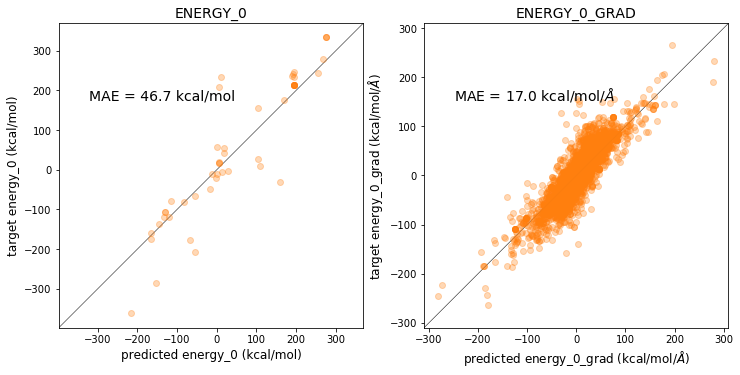

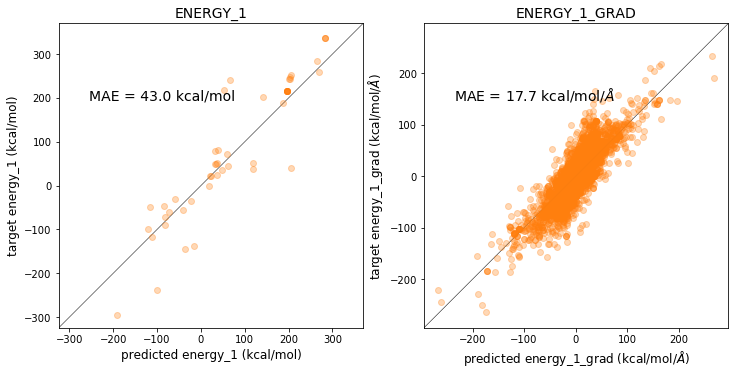

In [9]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)

plot_overall(results, targets)

AuTopology is doing pretty well! Now we'll call the function `transfer_to_schnet`, which freezes the AuTopology parameters and adds the SchNet module to the output:

In [10]:
model.transfer_to_schnet()

Now we make a new trainer and train the new model, which itself contains a trained AuTopology force field and an un-trained SchNet model:

In [11]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)

    shutil.move(OUTDIR, newpath)
    

trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]



new_T = Trainer(
        model_path=OUTDIR,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )



In [12]:
new_T.train(device=DEVICE, n_epochs=N_EPOCHS)

               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-28 13:45:42 |     1 |     1.000e-04 |  2088.3975 |       2091.4396 |      53.6359 |           17.5825 |      52.3163 |           17.9863 |               0
2019-11-28 13:45:43 |     2 |     1.000e-04 |  2068.5156 |       2080.7949 |      53.1796 |           17.5543 |      52.0098 |           17.9524 |               0
2019-11-28 13:45:45 |     3 |     1.000e-04 |  2049.4052 |       2079.1207 |      52.7068 |           17.5249 |      51.6626 |           17.9164 |               0
2019-11-28 13:45:46 |     4 |     1.000e-04 |  2030.3861 |       2072.0463 |      52.1587 |           17.4899 |      51.2546 |           17.8756 |               0
2019-11-28 13:45:47 |     5 |     1.000e-04 |  2009.4015 |       2051.8667 |      51.4835 |           17.4539 |      50.8299 |           17.8272 |               0
2019-11-28 13:45:48 | 

2019-11-28 13:46:41 |    51 |     1.000e-04 |  1036.3616 |       1159.3889 |      29.9126 |           14.0747 |      30.0683 |           14.2797 |               0
2019-11-28 13:46:42 |    52 |     1.000e-04 |  1027.5105 |       1189.2200 |      31.6118 |           14.1027 |      34.0343 |           14.2973 |               0
2019-11-28 13:46:43 |    53 |     1.000e-04 |  1011.8761 |       1149.9844 |      29.4501 |           14.0364 |      31.1975 |           14.2162 |               0
2019-11-28 13:46:44 |    54 |     1.000e-04 |  1040.9575 |       1221.2788 |      34.8314 |           13.9527 |      36.5422 |           14.1436 |               0
2019-11-28 13:46:45 |    55 |     1.000e-04 |  1019.6769 |       1164.5311 |      32.3007 |           13.8648 |      32.0221 |           14.1018 |               0
2019-11-28 13:46:46 |    56 |     1.000e-04 |  1012.1695 |       1122.4204 |      28.9397 |           13.8739 |      28.9396 |           14.0846 |               0
2019-11-28 13:46:47 | 

2019-11-28 13:47:39 |   102 |     1.000e-04 |   709.7399 |        887.7809 |      24.5844 |           12.6060 |      26.3661 |           12.9927 |               0
2019-11-28 13:47:40 |   103 |     1.000e-04 |   712.6410 |        900.8710 |      26.6440 |           12.5838 |      28.1452 |           12.9751 |               0
2019-11-28 13:47:41 |   104 |     1.000e-04 |   727.5374 |        935.9211 |      29.6774 |           12.5499 |      30.9629 |           12.9476 |               0
2019-11-28 13:47:43 |   105 |     1.000e-04 |   753.8230 |        988.4654 |      33.1994 |           12.5026 |      34.0709 |           12.9087 |               0
2019-11-28 13:47:44 |   106 |     1.000e-04 |   776.1394 |        951.4165 |      30.9312 |           12.4397 |      31.9798 |           12.8728 |               0
2019-11-28 13:47:45 |   107 |     1.000e-04 |   751.7149 |        860.1690 |      22.9521 |           12.4000 |      23.6728 |           12.8720 |               0
2019-11-28 13:47:46 | 

2019-11-28 13:48:36 |   153 |     1.000e-04 |   568.3140 |        768.4980 |      21.3525 |           11.8288 |      22.7669 |           12.3897 |               0
2019-11-28 13:48:37 |   154 |     1.000e-04 |   577.8013 |        787.8689 |      22.8715 |           11.8354 |      24.4817 |           12.3817 |               0
2019-11-28 13:48:38 |   155 |     1.000e-04 |   580.0337 |        760.0857 |      20.4752 |           11.7838 |      21.8371 |           12.3666 |               0
2019-11-28 13:48:39 |   156 |     1.000e-04 |   563.4632 |        748.4435 |      19.2564 |           11.7626 |      19.4704 |           12.3732 |               0
2019-11-28 13:48:41 |   157 |     1.000e-04 |   554.4873 |        748.0908 |      19.5022 |           11.7506 |      19.5796 |           12.3450 |               0
2019-11-28 13:48:42 |   158 |     1.000e-04 |   550.2528 |        744.5057 |      19.0449 |           11.7569 |      19.3487 |           12.3366 |               0
2019-11-28 13:48:43 | 

2019-11-28 13:49:33 |   204 |     1.000e-04 |   472.3607 |        707.8508 |      20.0744 |           11.2811 |      21.4001 |           11.9151 |               0
2019-11-28 13:49:34 |   205 |     1.000e-04 |   484.7690 |        716.1929 |      20.7660 |           11.2818 |      21.9313 |           11.9155 |               0
2019-11-28 13:49:35 |   206 |     1.000e-04 |   485.3799 |        686.2471 |      18.1305 |           11.2636 |      18.9568 |           11.9031 |               0
2019-11-28 13:49:37 |   207 |     1.000e-04 |   473.6733 |        673.8971 |      16.8248 |           11.2238 |      16.4627 |           11.8775 |               0
2019-11-28 13:49:38 |   208 |     1.000e-04 |   468.9155 |        695.6860 |      19.3004 |           11.1969 |      18.8669 |           11.8691 |               0
2019-11-28 13:49:39 |   209 |     1.000e-04 |   469.2336 |        692.3001 |      19.2372 |           11.1949 |      18.8587 |           11.8616 |               0
2019-11-28 13:49:40 | 

2019-11-28 13:50:30 |   255 |     1.000e-04 |   414.7952 |        629.3965 |      15.7550 |           10.8221 |      15.5152 |           11.4659 |               0
2019-11-28 13:50:31 |   256 |     1.000e-04 |   406.6852 |        653.4647 |      17.7389 |           10.8591 |      18.6544 |           11.4828 |               0
2019-11-28 13:50:32 |   257 |     1.000e-04 |   427.5113 |        712.2827 |      23.0204 |           10.8973 |      24.6346 |           11.5245 |               0
2019-11-28 13:50:33 |   258 |     1.000e-04 |   446.8344 |        657.9994 |      18.5021 |           10.8427 |      19.1560 |           11.4745 |               0
2019-11-28 13:50:35 |   259 |     1.000e-04 |   423.0944 |        626.8369 |      15.9739 |           10.7574 |      15.4213 |           11.3977 |               0
2019-11-28 13:50:36 |   260 |     1.000e-04 |   415.3008 |        674.5689 |      20.8903 |           10.7365 |      20.2662 |           11.3942 |               0
2019-11-28 13:50:37 | 

2019-11-28 13:51:27 |   306 |     1.000e-04 |   353.6357 |        620.8252 |      17.4873 |           10.5070 |      18.6384 |           11.0892 |               0
2019-11-28 13:51:28 |   307 |     1.000e-04 |   373.1547 |        648.8889 |      19.9908 |           10.5623 |      21.6877 |           11.1461 |               0
2019-11-28 13:51:29 |   308 |     1.000e-04 |   376.7051 |        592.2323 |      14.4803 |           10.5050 |      14.6501 |           11.0905 |               0
2019-11-28 13:51:30 |   309 |     1.000e-04 |   357.0125 |        604.6068 |      16.5503 |           10.4188 |      15.8051 |           11.0027 |               0
2019-11-28 13:51:31 |   310 |     1.000e-04 |   357.7838 |        624.4559 |      18.5262 |           10.4062 |      18.3342 |           11.0013 |               0
2019-11-28 13:51:33 |   311 |     1.000e-04 |   358.1458 |        585.3512 |      14.1472 |           10.4164 |      14.1284 |           11.0125 |               0
2019-11-28 13:51:34 | 

2019-11-28 13:52:24 |   357 |     1.000e-04 |   312.6556 |        589.8813 |      17.3910 |           10.1327 |      16.9648 |           10.6521 |               0
2019-11-28 13:52:25 |   358 |     1.000e-04 |   317.5983 |        581.7061 |      16.3034 |           10.1334 |      16.3429 |           10.6670 |               0
2019-11-28 13:52:26 |   359 |     1.000e-04 |   312.2350 |        556.6950 |      13.2214 |           10.1494 |      13.2340 |           10.6770 |               0
2019-11-28 13:52:27 |   360 |     1.000e-04 |   310.5883 |        601.2962 |      18.1941 |           10.2087 |      19.8169 |           10.7193 |               0
2019-11-28 13:52:28 |   361 |     1.000e-04 |   328.0689 |        580.0730 |      15.8253 |           10.2268 |      17.1090 |           10.7402 |               0
2019-11-28 13:52:30 |   362 |     1.000e-04 |   315.5155 |        557.0875 |      13.2304 |           10.1531 |      12.4826 |           10.6529 |               0
2019-11-28 13:52:31 | 

Now we'll evaluate the results:

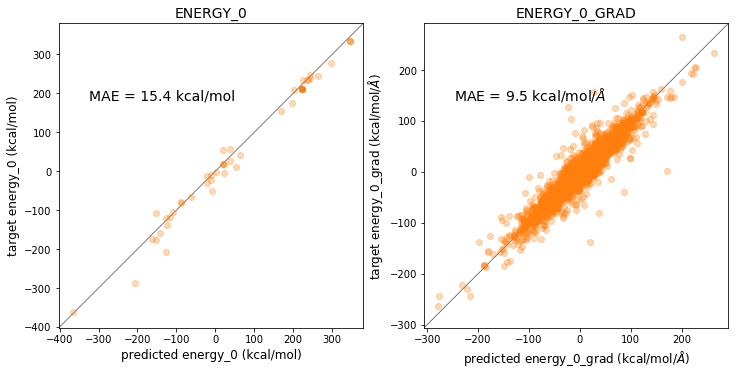

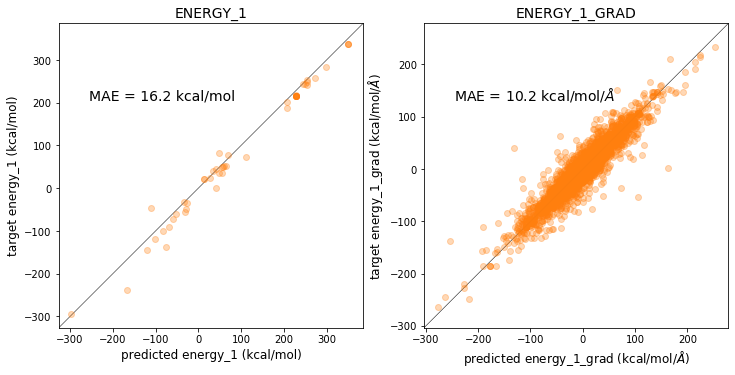

In [13]:
results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE)


plot_overall(results, targets)

We can also extract just the AuTopology part of the model, in case we're interested in it:

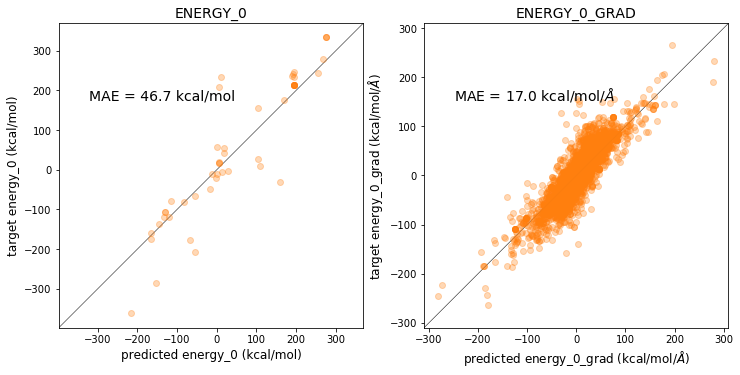

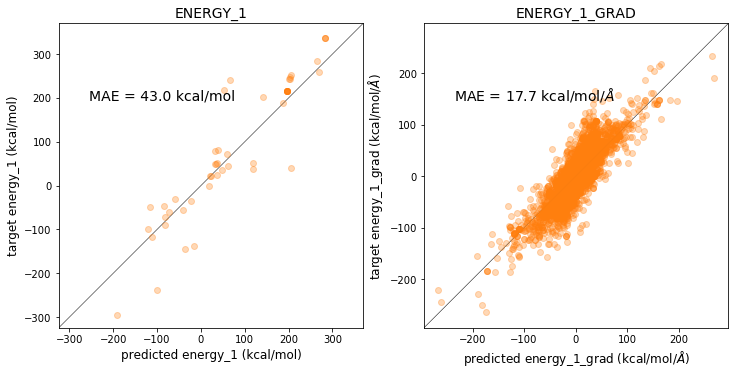

In [14]:
auto_results, targets, val_loss = evaluate(model, test_loader, loss_fn, device=DEVICE, submodel="autopology")


plot_overall(auto_results, targets)

The results are the same as the results in the first part of the training, as they should be!

## II. Comparison to regular SchNet

Now let's compare to regular SchNet

In [15]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)


    shutil.move(OUTDIR, newpath)

# create a new model and set "model_type" to "SchNet"

new_model = get_model(schnet_params, model_type="SchNet")
trainable_params = filter(lambda p: p.requires_grad, new_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]



newest_T = Trainer(
        model_path=OUTDIR,
        model=new_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [16]:
newest_T.train(device=DEVICE, n_epochs=N_EPOCHS)


               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-28 13:53:14 |     1 |     1.000e-04 | 13036.2510 |      12695.0478 |     163.8254 |           36.4133 |     155.6757 |           36.0062 |               0
2019-11-28 13:53:15 |     2 |     1.000e-04 | 12530.5960 |      12477.1114 |     161.9526 |           36.4132 |     150.9026 |           36.0328 |               0
2019-11-28 13:53:15 |     3 |     1.000e-04 | 12073.5599 |      12387.5365 |     160.0928 |           36.4139 |     147.2251 |           36.0692 |               0
2019-11-28 13:53:15 |     4 |     1.000e-04 | 11688.0732 |      12572.8999 |     158.8197 |           36.4079 |     144.3906 |           36.1024 |               0
2019-11-28 13:53:16 |     5 |     1.000e-04 | 11519.1364 |      12934.6038 |     157.5899 |           36.3597 |     143.0457 |           36.0613 |               0
2019-11-28 13:53:16 | 

2019-11-28 13:53:35 |    51 |     1.000e-04 |  2422.4446 |       3114.0960 |      55.4752 |           22.4258 |      49.2970 |           21.4851 |               0
2019-11-28 13:53:35 |    52 |     1.000e-04 |  2415.3987 |       3168.1699 |      56.5820 |           22.2127 |      52.3468 |           21.2753 |               0
2019-11-28 13:53:36 |    53 |     1.000e-04 |  2328.3071 |       2949.6397 |      55.6802 |           22.0506 |      49.0967 |           21.1056 |               0
2019-11-28 13:53:36 |    54 |     1.000e-04 |  2223.7516 |       2774.2516 |      55.0588 |           21.9568 |      48.9807 |           21.0186 |               0
2019-11-28 13:53:37 |    55 |     1.000e-04 |  2228.4592 |       2675.2944 |      51.1836 |           21.7433 |      45.5395 |           20.8438 |               0
2019-11-28 13:53:37 |    56 |     1.000e-04 |  2245.7960 |       2938.8807 |      54.9861 |           21.5152 |      51.3838 |           20.6521 |               0
2019-11-28 13:53:38 | 

2019-11-28 13:53:56 |   102 |     1.000e-04 |  1297.4204 |       1557.3155 |      30.1525 |           18.0896 |      28.9081 |           17.2902 |               0
2019-11-28 13:53:57 |   103 |     1.000e-04 |  1258.7155 |       1514.1713 |      33.2898 |           17.9339 |      28.9380 |           17.1662 |               0
2019-11-28 13:53:57 |   104 |     1.000e-04 |  1249.3303 |       1472.6060 |      30.8096 |           17.8338 |      27.2810 |           17.0764 |               0
2019-11-28 13:53:57 |   105 |     1.000e-04 |  1251.3314 |       1520.0639 |      31.0592 |           17.8656 |      29.9123 |           17.0824 |               0
2019-11-28 13:53:58 |   106 |     1.000e-04 |  1281.0753 |       1551.9121 |      32.8281 |           17.8426 |      30.9396 |           17.0489 |               0
2019-11-28 13:53:58 |   107 |     1.000e-04 |  1232.5269 |       1470.1313 |      33.5763 |           17.6614 |      29.3197 |           16.9060 |               0
2019-11-28 13:53:59 | 

2019-11-28 13:54:17 |   153 |     1.000e-04 |  1060.8202 |       1394.6063 |      37.3752 |           16.0176 |      36.7484 |           15.3456 |               0
2019-11-28 13:54:18 |   154 |     1.000e-04 |  1176.3055 |       1107.8219 |      22.5812 |           15.7853 |      19.6696 |           15.1740 |               0
2019-11-28 13:54:18 |   155 |     1.000e-04 |   966.7143 |       1174.8148 |      30.5705 |           15.6155 |      26.8773 |           15.0683 |               0
2019-11-28 13:54:18 |   156 |     1.000e-04 |   991.8504 |       1157.3034 |      26.2388 |           15.7706 |      25.5912 |           15.1291 |               0
2019-11-28 13:54:19 |   157 |     1.000e-04 |   966.6923 |       1093.8246 |      21.3846 |           15.7421 |      20.4419 |           15.1118 |               0
2019-11-28 13:54:19 |   158 |     1.000e-04 |   917.7583 |       1074.1815 |      23.3611 |           15.6494 |      20.1907 |           15.0419 |               0
2019-11-28 13:54:20 | 

2019-11-28 13:54:39 |   204 |     1.000e-04 |   766.7029 |        897.4972 |      20.3478 |           14.3036 |      17.6758 |           13.8474 |               0
2019-11-28 13:54:39 |   205 |     1.000e-04 |   760.9787 |        890.3690 |      19.7795 |           14.2621 |      16.6261 |           13.8181 |               0
2019-11-28 13:54:39 |   206 |     1.000e-04 |   759.5410 |        913.8143 |      19.6372 |           14.2976 |      19.6711 |           13.8281 |               0
2019-11-28 13:54:40 |   207 |     1.000e-04 |   766.3048 |        898.4484 |      18.4619 |           14.2579 |      18.1331 |           13.7917 |               0
2019-11-28 13:54:40 |   208 |     1.000e-04 |   745.8228 |        885.7783 |      20.8768 |           14.1745 |      17.6259 |           13.7403 |               0
2019-11-28 13:54:41 |   209 |     1.000e-04 |   752.8007 |        876.5065 |      17.2501 |           14.1745 |      15.2735 |           13.7313 |               0
2019-11-28 13:54:41 | 

2019-11-28 13:55:00 |   255 |     1.000e-04 |   690.0625 |        810.3401 |      19.9319 |           13.2580 |      18.9603 |           12.8920 |               0
2019-11-28 13:55:01 |   256 |     1.000e-04 |   662.2387 |        795.1222 |      21.1730 |           13.1460 |      17.7107 |           12.8292 |               0
2019-11-28 13:55:01 |   257 |     1.000e-04 |   684.5194 |        777.9672 |      16.5196 |           13.1725 |      14.9747 |           12.8368 |               0
2019-11-28 13:55:01 |   258 |     1.000e-04 |   681.4833 |        877.5449 |      25.9991 |           13.2345 |      25.1963 |           12.8600 |               0
2019-11-28 13:55:02 |   259 |     1.000e-04 |   709.1011 |        795.8156 |      21.8613 |           13.1498 |      18.7989 |           12.8066 |               0
2019-11-28 13:55:02 |   260 |     1.000e-04 |   682.2559 |        830.7962 |      24.9436 |           13.0419 |      21.3655 |           12.7455 |               0
2019-11-28 13:55:03 | 

2019-11-28 13:55:22 |   306 |     1.000e-04 |   559.6006 |        674.7734 |      13.8767 |           12.3624 |      12.2341 |           12.1025 |               0
2019-11-28 13:55:22 |   307 |     1.000e-04 |   555.5887 |        671.2823 |      13.9511 |           12.3356 |      11.0768 |           12.0829 |               0
2019-11-28 13:55:23 |   308 |     1.000e-04 |   555.2285 |        671.6598 |      13.3092 |           12.3199 |      12.3637 |           12.0686 |               0
2019-11-28 13:55:23 |   309 |     1.000e-04 |   554.7216 |        678.3358 |      14.4107 |           12.3139 |      14.0614 |           12.0595 |               0
2019-11-28 13:55:23 |   310 |     1.000e-04 |   553.9428 |        668.6820 |      13.7206 |           12.2950 |      12.4022 |           12.0417 |               0
2019-11-28 13:55:24 |   311 |     1.000e-04 |   549.1052 |        664.1938 |      13.6979 |           12.2679 |      11.0267 |           12.0215 |               0
2019-11-28 13:55:24 | 

2019-11-28 13:55:43 |   357 |     1.000e-04 |   704.1617 |        662.0221 |      18.1546 |           11.7353 |      15.6465 |           11.5127 |               0
2019-11-28 13:55:43 |   358 |     1.000e-04 |   637.3302 |        823.5261 |      32.4633 |           11.8329 |      32.2038 |           11.6010 |               0
2019-11-28 13:55:44 |   359 |     1.000e-04 |   661.1538 |        747.0273 |      24.4873 |           11.7057 |      23.0789 |           11.4832 |               0
2019-11-28 13:55:44 |   360 |     1.000e-04 |   688.2377 |        861.6165 |      33.5996 |           11.7370 |      30.4733 |           11.5481 |               0
2019-11-28 13:55:44 |   361 |     1.000e-04 |   647.9229 |        756.0041 |      27.8836 |           11.5516 |      25.0185 |           11.4192 |               0
2019-11-28 13:55:45 |   362 |     1.000e-04 |   672.1126 |        716.5242 |      22.5352 |           11.8027 |      22.6137 |           11.6008 |               0
2019-11-28 13:55:45 | 

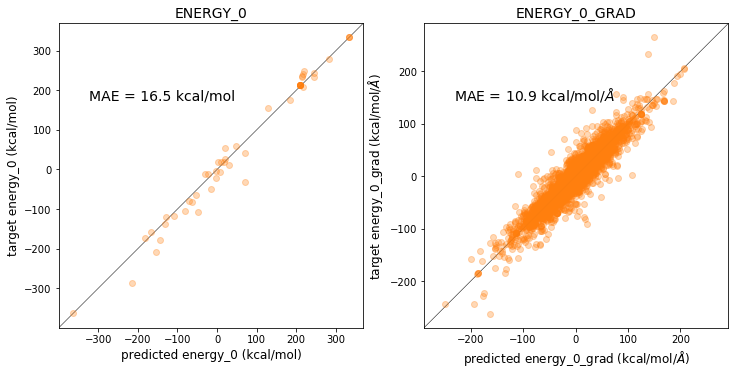

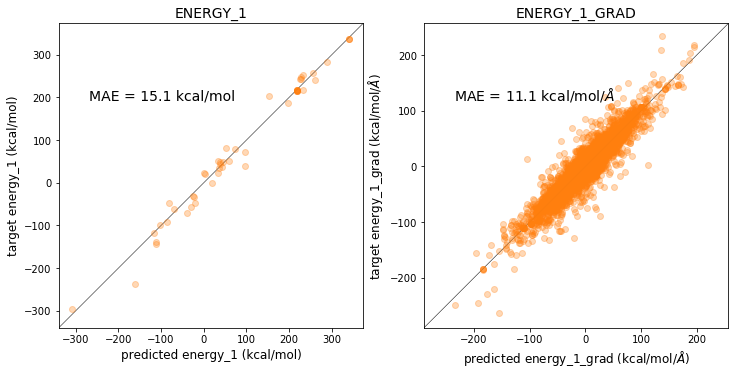

In [17]:
new_results, new_targets, new_val_loss = evaluate(new_model, test_loader, loss_fn, device=DEVICE)

plot_overall(new_results, new_targets)

The AuTopology + SchNet results are quite comparable to the SchNet results. This is great news, because it means we can get the same accuracy but with much of the answer coming from well-behaved functional forms for the energy. SchNet + AuTopology will therefore keep the molecule together during an MD run, even if there's a new geometry that hasn't been seen before. This means that the combination of SchNet + AuTopology should be more stable in MD runs than regular SchNet.

# III. Non-trainable AuTopology

Lastly, we can compare to AuTopology + SchNet, where the AuTopology parameters can't be learned. To do so we set `trainable_prior` to False. 

We also change `bond_terms` to `harmonic`, because there is a baseline spring constant to which learned parameters are added. That means that even if we don't learn any parameters, we'd still get a spring constant that keeps the molecule together. The `morse` option, on the other hand, doesn't have such as base-line spring constant, so it wouldn't help us!

In [18]:
last_params = copy.deepcopy(params)
last_params["autopology_params"]["trainble_prior"] = False
last_params["autopology_params"]["bond_terms"] = ["harmonic"]

last_model = get_model(last_params, model_type="SchNetAuTopology", add_autopology=True, add_schnet=True)



In [19]:
if os.path.exists(OUTDIR):
    newpath = os.path.join(os.path.dirname(OUTDIR), 'backup')
    if os.path.exists(newpath):
        shutil.rmtree(newpath)


    shutil.move(OUTDIR, newpath)


trainable_params = filter(lambda p: p.requires_grad, last_model.parameters())
optimizer = Adam(trainable_params, lr=1e-4)

train_hooks = [
    hooks.MaxEpochHook(3000),
    hooks.CSVHook(
        OUTDIR,
        metrics=train_metrics,
    ),
    hooks.PrintingHook(
        OUTDIR,
        metrics=train_metrics,
        separator = ' | '
    ),
    hooks.ReduceLROnPlateauHook(
        optimizer=optimizer,
        patience=30,
        factor=0.5,
        min_lr=1e-7,
        window_length=1,
        stop_after_min=True
    )
]

last_T = Trainer(
        model_path=OUTDIR,
        model=last_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_loader=train_loader,
        validation_loader=val_loader,
        checkpoint_interval=1,
        hooks=train_hooks,
        mini_batches=2
    )


In [20]:
last_T.train(device=DEVICE, n_epochs=200)


               Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_0 | MAE_energy_0_grad | MAE_energy_1 | MAE_energy_1_grad | GPU Memory (MB)
2019-11-28 13:56:02 |     1 |     1.000e-04 | 43117.2422 |      27635.4984 |     248.6571 |           38.3328 |     225.5261 |           38.0484 |               0
2019-11-28 13:56:04 |     2 |     1.000e-04 | 30066.3021 |      21852.0504 |     217.6982 |           38.1115 |     199.2059 |           37.3070 |               0
2019-11-28 13:56:05 |     3 |     1.000e-04 | 23586.9935 |      17678.5143 |     194.4655 |           38.1131 |     181.6482 |           37.2377 |               0
2019-11-28 13:56:06 |     4 |     1.000e-04 | 18891.4811 |      14780.8354 |     176.1812 |           38.2394 |     169.0152 |           37.3842 |               0
2019-11-28 13:56:07 |     5 |     1.000e-04 | 15394.5895 |      12729.8926 |     156.4190 |           38.5099 |     156.6191 |           37.6172 |               0
2019-11-28 13:56:08 | 

2019-11-28 13:57:04 |    51 |     1.000e-04 |  2718.6444 |       2957.4996 |      37.1505 |           22.0757 |      43.9310 |           22.1446 |               0
2019-11-28 13:57:05 |    52 |     1.000e-04 |  2704.9881 |       2883.4701 |      42.2440 |           21.8232 |      45.9907 |           21.9217 |               0
2019-11-28 13:57:06 |    53 |     1.000e-04 |  2786.4408 |       3076.1971 |      61.0955 |           21.5845 |      55.6754 |           21.7077 |               0
2019-11-28 13:57:07 |    54 |     1.000e-04 |  2911.5980 |       2974.2768 |      59.2048 |           21.3649 |      52.5186 |           21.5042 |               0
2019-11-28 13:57:09 |    55 |     1.000e-04 |  2674.3475 |       2765.2610 |      37.4888 |           21.1735 |      43.4572 |           21.3350 |               0
2019-11-28 13:57:10 |    56 |     1.000e-04 |  2534.3936 |       2959.8797 |      50.1271 |           20.9838 |      44.4019 |           21.1707 |               0
2019-11-28 13:57:11 | 

2019-11-28 13:58:04 |   102 |     1.000e-04 |  1606.1358 |       1938.2493 |      37.1271 |           17.1813 |      37.7161 |           17.2726 |               0
2019-11-28 13:58:05 |   103 |     1.000e-04 |  1570.7768 |       1865.6751 |      27.2465 |           17.1947 |      34.4219 |           17.2555 |               0
2019-11-28 13:58:07 |   104 |     1.000e-04 |  1523.6860 |       1889.0867 |      28.3868 |           17.1545 |      33.5055 |           17.2059 |               0
2019-11-28 13:58:08 |   105 |     1.000e-04 |  1527.6996 |       1859.7092 |      29.3561 |           17.0377 |      35.2662 |           17.1044 |               0
2019-11-28 13:58:09 |   106 |     1.000e-04 |  1538.9482 |       1877.7448 |      34.9533 |           16.9678 |      37.0050 |           17.0297 |               0
2019-11-28 13:58:10 |   107 |     1.000e-04 |  1516.7337 |       1808.6189 |      27.7032 |           16.9608 |      34.0264 |           16.9937 |               0
2019-11-28 13:58:11 | 

2019-11-28 13:59:05 |   153 |     1.000e-04 |  1152.0859 |       1509.1118 |      27.2231 |           15.2914 |      29.8366 |           15.2037 |               0
2019-11-28 13:59:06 |   154 |     1.000e-04 |  1195.7493 |       1557.3105 |      36.7347 |           15.2834 |      37.7132 |           15.2065 |               0
2019-11-28 13:59:08 |   155 |     1.000e-04 |  1227.8008 |       1447.6173 |      27.1532 |           15.2492 |      29.5061 |           15.1718 |               0
2019-11-28 13:59:09 |   156 |     1.000e-04 |  1155.8463 |       1550.6650 |      29.0170 |           15.2167 |      28.8919 |           15.1208 |               0
2019-11-28 13:59:10 |   157 |     1.000e-04 |  1176.2358 |       1596.8408 |      31.2554 |           15.1866 |      32.2645 |           15.0928 |               0
2019-11-28 13:59:11 |   158 |     1.000e-04 |  1164.1989 |       1509.0711 |      30.6535 |           15.1186 |      32.5685 |           15.0490 |               0
2019-11-28 13:59:13 | 

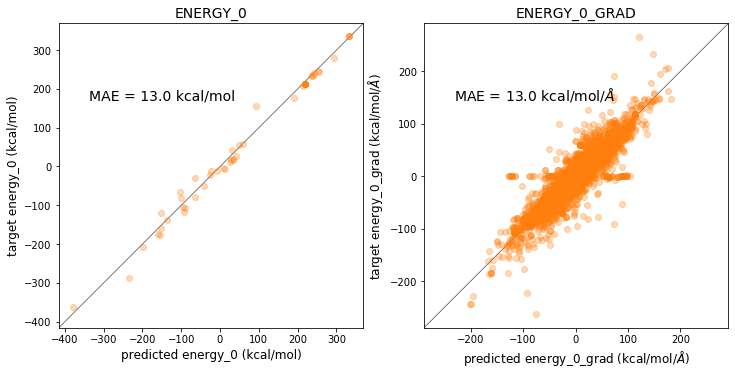

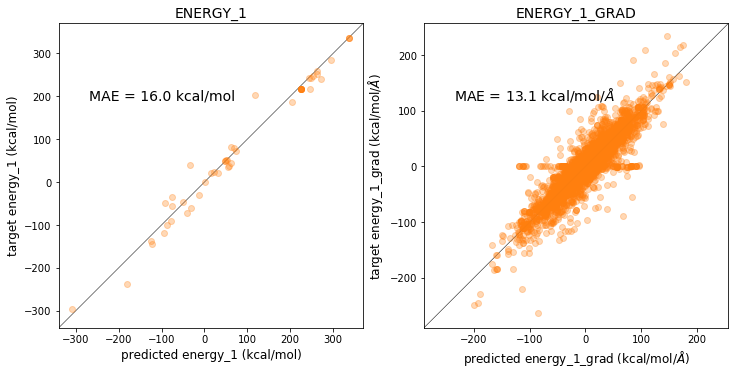

In [21]:
last_results, last_targets, last_vall_loss = evaluate(last_model, test_loader, loss_fn, device=DEVICE)

plot_overall(last_results, last_targets)

The classical priors for the gradients are very loosely correlated with the actual results:

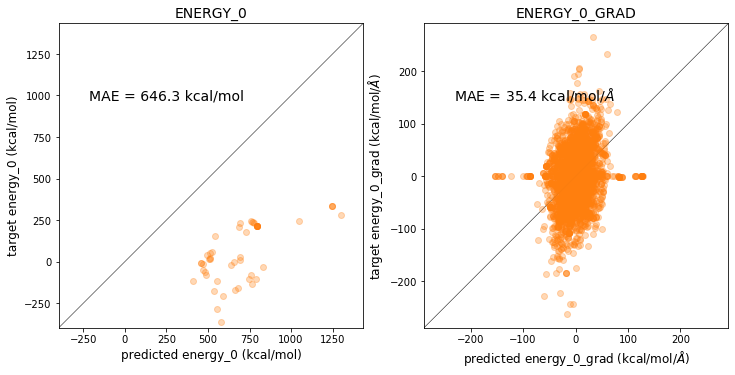

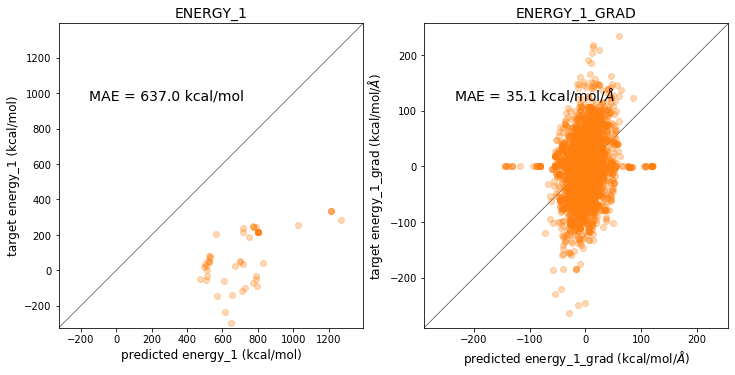

In [22]:
auto_results, targets, val_loss = evaluate(last_model, test_loader, loss_fn, device=DEVICE, submodel="autopology")


plot_overall(auto_results, targets)